In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis, zscore
from dython.nominal import associations 
from sklearn.ensemble import RandomForestClassifier, VotingClassifier  
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
import joblib

In [2]:
df = pd.read_csv('SaZ_clientes.csv', sep=';')

# **1.Data treatment and cleaning**


In [3]:
df.head() # Mostra the primeres files del DataFrame

,id,sexo,edad,permiso_conducir,region,extension_garantia,antiguedad_vehiculo,precio,siniestro,prima,salario,oficina,antiguedad,respuesta
0,1,Male,44.0,1,28.0,0,> 2 Years,4219.0,Yes,40454.0,3584.0,26.0,217,1
1,2,Male,76.0,1,3.0,0,1-2 Year,7496.0,No,33536.0,8541.0,26.0,183,0
2,3,Male,NaN,1,28.0,0,> 2 Years,3619.0,Yes,38294.0,4819.0,26.0,27,1
3,4,NaN,21.0,1,11.0,1,< 1 Year,1736.0,No,28619.0,1325.0,152.0,203,0
4,5,Female,29.0,1,41.0,1,< 1 Year,2661.0,No,27496.0,3067.0,152.0,39,0


First of all, let's take note of how many data entries we have and how many of them correspond to churn (1).

In [4]:
df['respuesta'].value_counts() # Mostra the valors únics of la columna 'permiso_conducir'

respuesta
0    336400
1     46710
Name: count, dtype: int64

We see that we have a total of 383,110 entries, and of these, 46,710 correspond to churn (12%). It seems that the column *permiso\_conducir* is the same for all entries—let's verify that:

In [5]:
df['permiso_conducir'].value_counts() # Comptar la freqüència of cada valor únic

permiso_conducir
1    382298
0       812
Name: count, dtype: int64

In [6]:
df[(df['permiso_conducir'] == 0) & (df['respuesta'] == 1)].shape[0]
# Comptar el nombre of clients que no tenen permís of conduir i han acceptat la proposta

41

We observe that the sample of people without a driving license has a different churn rate (5%), but the volume of data is insignificant compared to the large dataset we have. To reduce model noise, improve computational efficiency, and avoid overfitting, we hypothesize that it is better to remove this variable. However, we will wait for the correlation analysis with other variables before doing so. What we do remove for now is the *id* column.

In [7]:
df.drop(columns=['id'], inplace=True)

In [8]:
# Resum general
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383110 entries, 0 to 383109
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   sexo                 352735 non-null  object 
 1   edad                 345043 non-null  float64
 2   permiso_conducir     383110 non-null  int64  
 3   region               383110 non-null  float64
 4   extension_garantia   383110 non-null  int64  
 5   antiguedad_vehiculo  367930 non-null  object 
 6   precio               383110 non-null  float64
 7   siniestro            383110 non-null  object 
 8   prima                383110 non-null  float64
 9   salario              371621 non-null  float64
 10  oficina              383110 non-null  float64
 11  antiguedad           383110 non-null  int64  
 12  respuesta            383110 non-null  int64  
dtypes: float64(6), int64(4), object(3)
memory usage: 38.0+ MB


We notice that there are missing values in *sexo*, *edad*, *antiguedad\_vehiculo*, and *salario*. Let's first analyze the quantitative variables:

In [9]:
print(df.describe())

                edad  permiso_conducir         region  extension_garantia  \
count  345043.000000     383110.000000  383110.000000        383110.00000   
mean       38.727759          0.997881      26.292762             0.46104   
std        15.513268          0.045989      13.261700             0.49848   
min        20.000000          0.000000       0.000000             0.00000   
25%        24.000000          1.000000      15.000000             0.00000   
50%        36.000000          1.000000      28.000000             0.00000   
75%        49.000000          1.000000      35.000000             1.00000   
max        85.000000          1.000000      52.000000             1.00000   

              precio          prima        salario        oficina  \
count  383110.000000  383110.000000  371621.000000  383110.000000   
mean     3877.164026   30838.289144    3871.138544     112.237814   
std      1699.053400   17579.352378    1703.190991      54.135166   
min         2.000000    2630.0

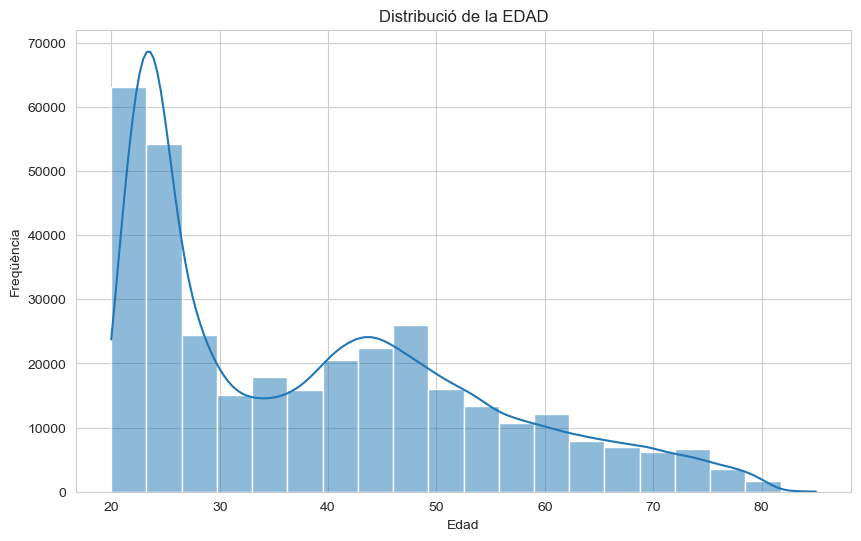

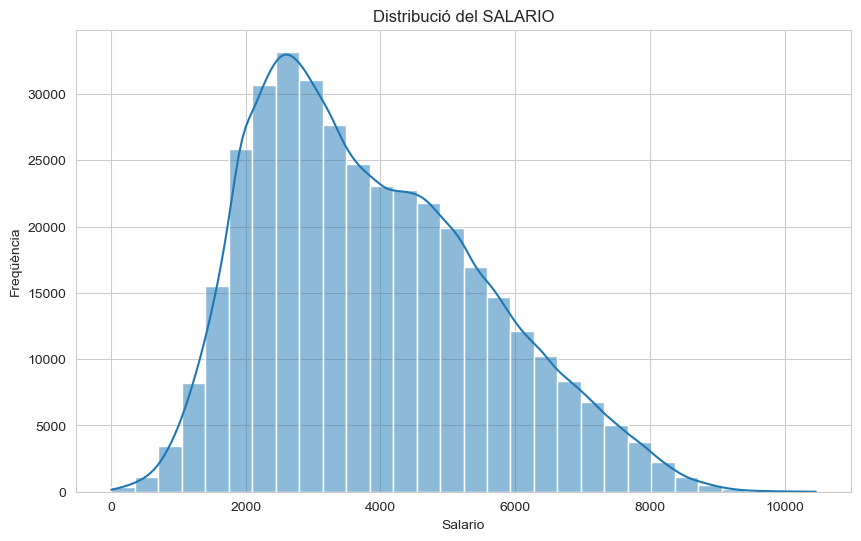

In [10]:
# Configuració to a la visualització dels gràfics
sns.set_style("whitegrid") # Estil of fons blanc with quadrícula
plt.rcParams["figure.figsize"] = (10, 6) # Mida to defecte dels gràfics

# --- 1. Histograma to a la columna 'edad' ---
sns.histplot(data=df, x='edad', kde=True, bins=20)
plt.title('Distribució de la EDAD')
plt.xlabel('Edad')
plt.ylabel('Freqüència')
plt.show()

# --- 2. Histograma to a la columna 'salario' ---
sns.histplot(data=df, x='salario', kde=True, bins=30)
plt.title('Distribució del SALARIO')
plt.xlabel('Salario')
plt.ylabel('Freqüència')
plt.show()

We observe that the 20 to 26 age group is highly represented in *Edad*. Nevertheless, the mean and median are very similar (generally across all the data). As for *salario*, it follows the typical distribution of salaries, with no significant outliers. None of the variables follow a Gaussian distribution, so we will fill the missing values using the median.

In [11]:
df['edad'] = df['edad'].fillna(df['edad'].median())
df['salario'] = df['salario'].fillna(df['salario'].median())

Let's analyze the *Sexo* column.

In [12]:
df['sexo'].value_counts()

sexo
Male      191651
Female    161084
Name: count, dtype: int64

In [ ]:
print(f"The churn rate among men   is: {100*df[(df['sexo'] == 'Male') & (df['respuesta'] == 1)].shape[0]/df[(df['sexo']=='Male')].shape[0]} %")
print(f"The churn rate among women is: {100*df[(df['sexo'] == 'Female') & (df['respuesta'] == 1)].shape[0]/df[(df['sexo']=='Female')].shape[0]} %")

El percentatge d'abandonament en homes és de: 13.676944028468414 %
El percentatge d'abandonament en dones és de: 10.325668595267066 %


There is a 7.9% of missing entries in the *Sexo* column. We've just seen that the number of males and females is roughly balanced, so replacing the missing values with the mode would introduce too much bias.

Moreover, we observed earlier that there is a differentiated churn behavior between men and women (a 3.35% difference), so it doesn’t make sense to drop the column as we plan to do with *permiso\_conducir*.

Instead, when implementing the model, we will create a third category, *Unknown*, to avoid biasing the data—especially since those who left the field blank may have selected options like "Other" or "Prefer not to say," which are often provided.

In [14]:
df['sexo'].fillna('Desconegut', inplace=True)

Let's now address the *antiguedad_vehiculo*:

In [ ]:
print(df['antiguedad_vehiculo'].value_counts())
print(f"The churn rate among <1 year is: {100*df[(df['antiguedad_vehiculo'] == '< 1 Year') & (df['respuesta'] == 1)].shape[0]/df[(df['antiguedad_vehiculo']=='< 1 Year')].shape[0]} %")
print(f"The churn rate among 1-2 years is: {100*df[(df['antiguedad_vehiculo'] == '1-2 Year') & (df['respuesta'] == 1)].shape[0]/df[(df['antiguedad_vehiculo']=='1-2 Year')].shape[0]} %")
print(f"The churn rate among > 2 anys is: {100*df[(df['antiguedad_vehiculo'] == '> 2 Years') & (df['respuesta'] == 1)].shape[0]/df[(df['antiguedad_vehiculo']=='> 2 Years')].shape[0]} %")
print(f"The churn rate among desconegut is: {100*df[(df['antiguedad_vehiculo'].isnull()) & (df['respuesta'] == 1)].shape[0]/df[(df['antiguedad_vehiculo'].isnull())].shape[0]} %")

antiguedad_vehiculo
1-2 Year     192333
< 1 Year     160179
> 2 Years     15418
Name: count, dtype: int64
El percentatge d'abandonament en <1 any és de: 4.307680782124998 %
El percentatge d'abandonament en 1-2 anys és de: 17.398990292877457 %
El percentatge d'abandonament en > 2 anys és de: 29.420158256583214 %
El percentatge d'abandonament en desconegut és de: 11.923583662714098 %


As we can see, this is a very important factor for the model and, therefore, we must treat it with great care. Since the absence of data could indicate that the churn rate is different, we will create another variable for "Unknown." This is preferable to deleting 4% of the data when the variation in the response is so large (ranging from 4% to 29%).


In [16]:
df['antiguedad_vehiculo'].fillna('Desconegut', inplace=True)

Another factor we’ve observed is **region** and **office**, with 52 and 163 unique values, respectively. Let’s take a look at this data:

In [17]:
counts_by_regio = df['region'].value_counts()
print(counts_by_regio)

region
28.0    106415
8.0      35878
46.0     19749
41.0     18263
15.0     13308
30.0     12191
29.0     11065
50.0     10243
3.0       9251
11.0      9232
36.0      8797
33.0      7654
47.0      7436
35.0      6942
6.0       6280
45.0      5605
37.0      5501
18.0      5153
48.0      4681
14.0      4678
39.0      4644
10.0      4374
21.0      4266
2.0       4038
13.0      4036
7.0       3279
12.0      3198
9.0       3101
27.0      2823
32.0      2787
43.0      2639
17.0      2617
26.0      2587
25.0      2503
24.0      2415
38.0      2026
0.0       2021
16.0      2007
31.0      1960
23.0      1960
20.0      1935
49.0      1832
4.0       1801
34.0      1664
19.0      1535
22.0      1309
40.0      1295
5.0       1279
1.0       1008
44.0       808
42.0       591
52.0       267
51.0       183
Name: count, dtype: int64


We can see that the regions correspond to the provinces of Spain, and the most (and least) populated ones have the highest (and lowest) number of contracts: Madrid, Barcelona, and Valencia (Ceuta, Melilla, and Soria). We observe that the data volume for the smaller provinces is large enough to be statistically useful, so we will leave them as they are. Now, let’s take a look at the offices:

In [18]:
counts_by_oficina = df['oficina'].value_counts()
print(counts_by_oficina)

oficina
152.0    134784
26.0      79700
124.0     73995
160.0     21779
156.0     10661
          ...  
149.0         1
43.0          1
144.0         1
143.0         1
41.0          1
Name: count, Length: 155, dtype: int64


We see that the top 5 offices account for more than 80% of the clients, while many others are very small (with just 1 client). Clearly, we won't be able to work with offices that have so few clients, as they would lead to overfitting.

With the **region** variable, we're assessing customer behavior based on their location. With the **office** variable, even though each office is located in a specific place, we're evaluating how each office performs—whether it's due to personnel, their skills in retaining clients, etc.

Therefore, this data is too valuable to discard, but it does require proper handling. Let’s assess how many small offices there are (where we define small offices as those with 25 or fewer clients, which, given an average churn rate of 12%, should yield roughly 3 churns according to the law of large numbers):

In [ ]:
counts_by_oficina = df['oficina'].value_counts()
oficines_petites = counts_by_oficina[counts_by_oficina <= 25]
print(f"Number of small: {len(oficines_petites)}")

Nombre d'oficines petites: 67


We will consider that if an office with more than 25 clients has a different churn rate than another, it's likely due to its management starting to have an influence, rather than the random behavior of just a few clients. Therefore, we will create a new variable for **small offices**, and we will leave the other offices as they are. This new variable will be labeled as **Office 164**.

As a result, 67 offices will no longer appear individually, but this is not an issue—this already happened before, and the variable is categorical anyway.

In [20]:
oficines_a_agrupar = df['oficina'].value_counts()[df['oficina'].value_counts() <= 25].index.tolist()
df.loc[df['oficina'].isin(oficines_a_agrupar), 'oficina'] = 164

# **2. EDA**
Let’s analyze the data a bit to identify which factors have the greatest influence on churn.

### 2.1 Categorical Data
We will start by studying the categorical variables, which are: sex, region, extended\_warranty, vehicle\_age, claim, and office. Let’s proceed to look at the relative frequency for each:

In [21]:
def print_categorical_eda(df, categorical_cols, target_col):
    """
    Imprimeix les freqüències, percentatges i la taxa d'abandonament
    per a cada categoria d'un conjunt de columnes categòriques.

    Args:
        df (pd.DataFrame): El DataFrame de dades.
        categorical_cols (list): Llista de noms de columnes categòriques a analitzar.
        target_col (str): Nom de la columna objectiu (variable de resposta, 0 o 1).
    """
    print("-" * 70)
    print("ANÀLISI EDA DE VARIABLES CATEGÒRIQUES")
    print("-" * 70)

    for col in categorical_cols:
        print(f"\n# ## Anàlisi of la variable: '{col}' ###")
        print("-" * (29 + len(col)))

        # 1. Freqüències i Percentatges
        counts = df[col].value_counts(dropna=False) # Inclou NaN si n'hi ha
        percentages = df[col].value_counts(normalize=True, dropna=False) * 100

        # Crear a DataFrame temporal to mostrar the freqüències
        freq_df = pd.DataFrame({
            'Count': counts,
            'Percentage (%)': percentages.round(2)
        })
        print("\nFreqüència i Percentatge de Categories:")
        print(freq_df)

        # 2. Taxa d'Abandonament to Categoria
        # Agrupa to la columna categòrica i calcula la mitjana of la variable objectiu
        # (ja que és 0 o 1, la mitjana és la proporció of 1s = taxa d'abandonament)
        churn_rate = df.groupby(col)[target_col].mean() * 100
        churn_rate_df = pd.DataFrame({
            'Taxa Abandonament (%)': churn_rate.round(2)
        })
        # Ordenar to taxa d'abandonament to facilitar la interpretació
        churn_rate_df = churn_rate_df.sort_values(by='Taxa Abandonament (%)', ascending=False)

        print("\nTaxa d'Abandonament per Categoria:")
        print(churn_rate_df)
        print("\n" + "=" * 60) # Separador to claredat

# Llista of the teves columnes categòriques
categorical_features = ['sexo', 'region', 'extension_garantia', 'antiguedad_vehiculo', 'siniestro', 'oficina']

# Executar la funció
print_categorical_eda(df, categorical_features, 'respuesta')

----------------------------------------------------------------------
ANÀLISI EDA DE VARIABLES CATEGÒRIQUES
----------------------------------------------------------------------

# ## Anàlisi of la variable: 'sexo' ###
---------------------------------

Freqüència i Percentatge de Categories:
             Count  Percentage (%)
sexo                              
Male        191651           50.03
Female      161084           42.05
Desconegut   30375            7.93

Taxa d'Abandonament per Categoria:
            Taxa Abandonament (%)
sexo                             
Male                        13.68
Desconegut                  12.72
Female                      10.33


# ## Anàlisi of la variable: 'region' ###
-----------------------------------

Freqüència i Percentatge de Categories:
         Count  Percentage (%)
region                        
28.0    106415           27.78
8.0      35878            9.36
46.0     19749            5.15
41.0     18263            4.77
15.0     13308  

----------------------------------------------------------------------
INICI DE L'EDA GRÀFICA PER VARIABLES CATEGÒRIQUES
----------------------------------------------------------------------

Generant gràfics per a la variable: 'sexo'...


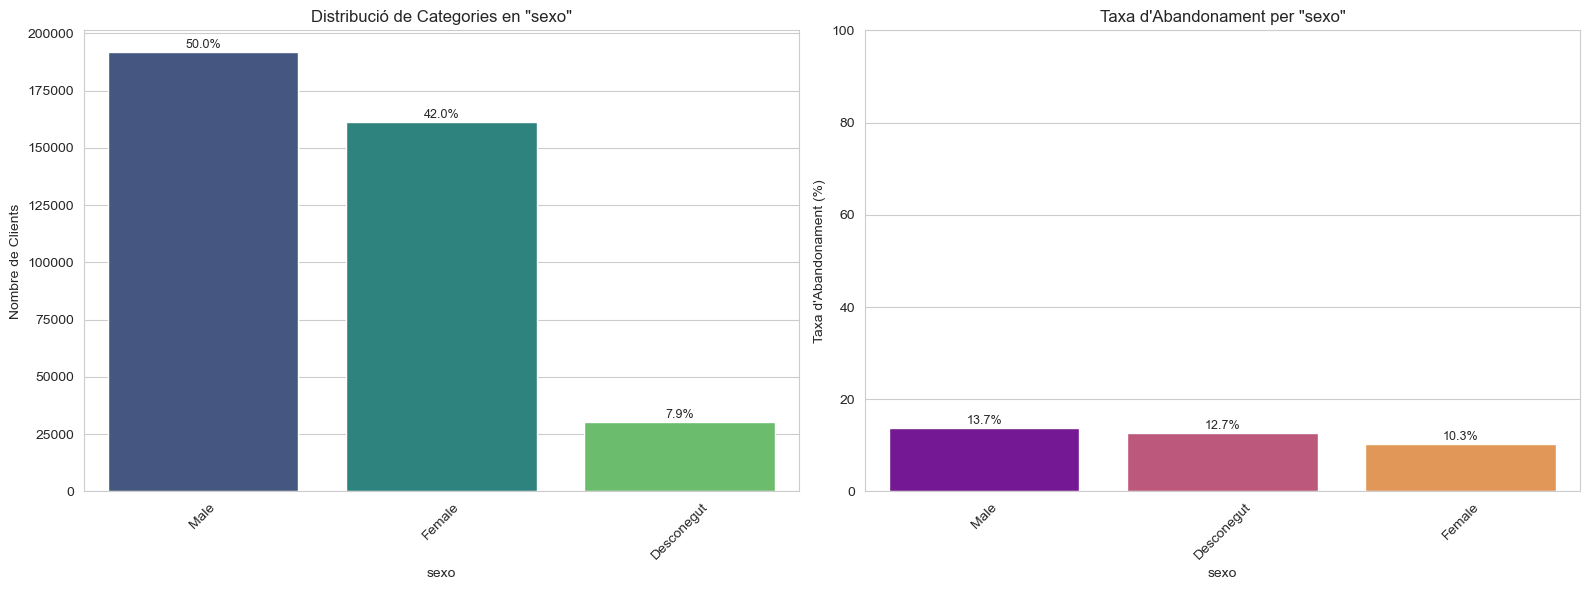




Generant gràfics per a la variable: 'region'...


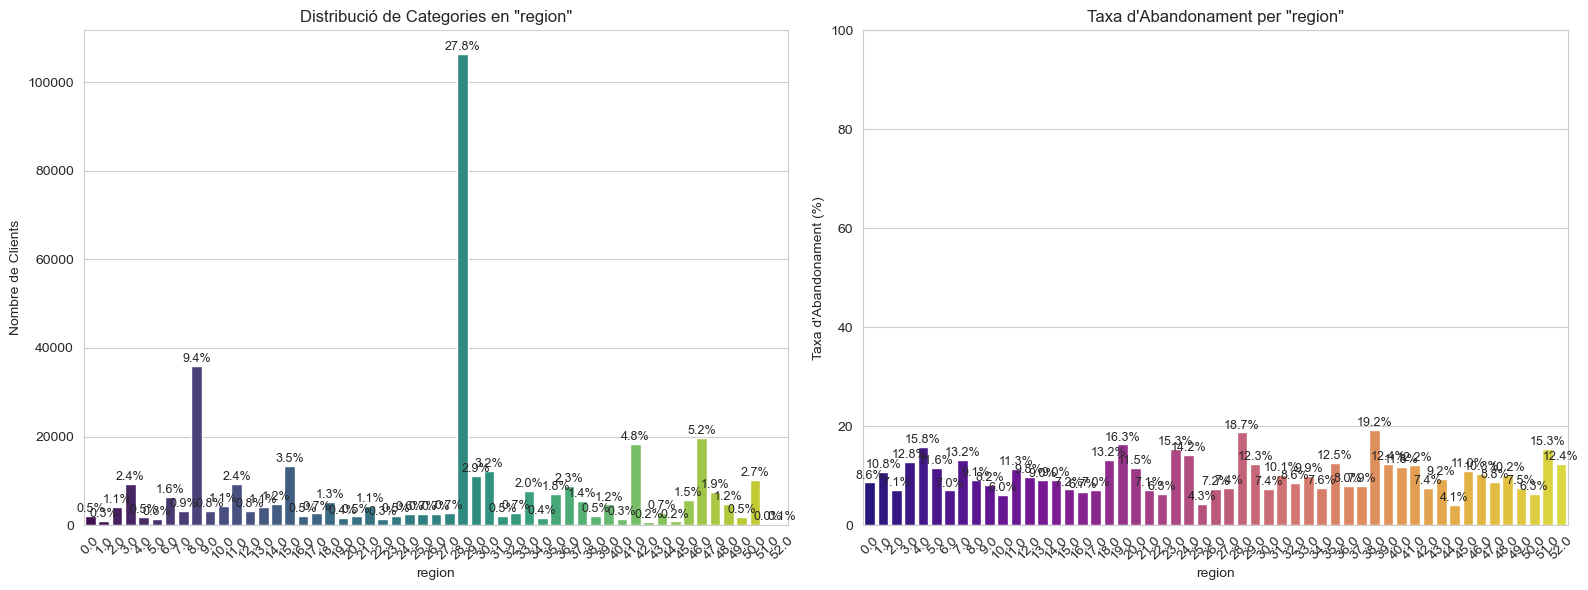




Generant gràfics per a la variable: 'extension_garantia'...


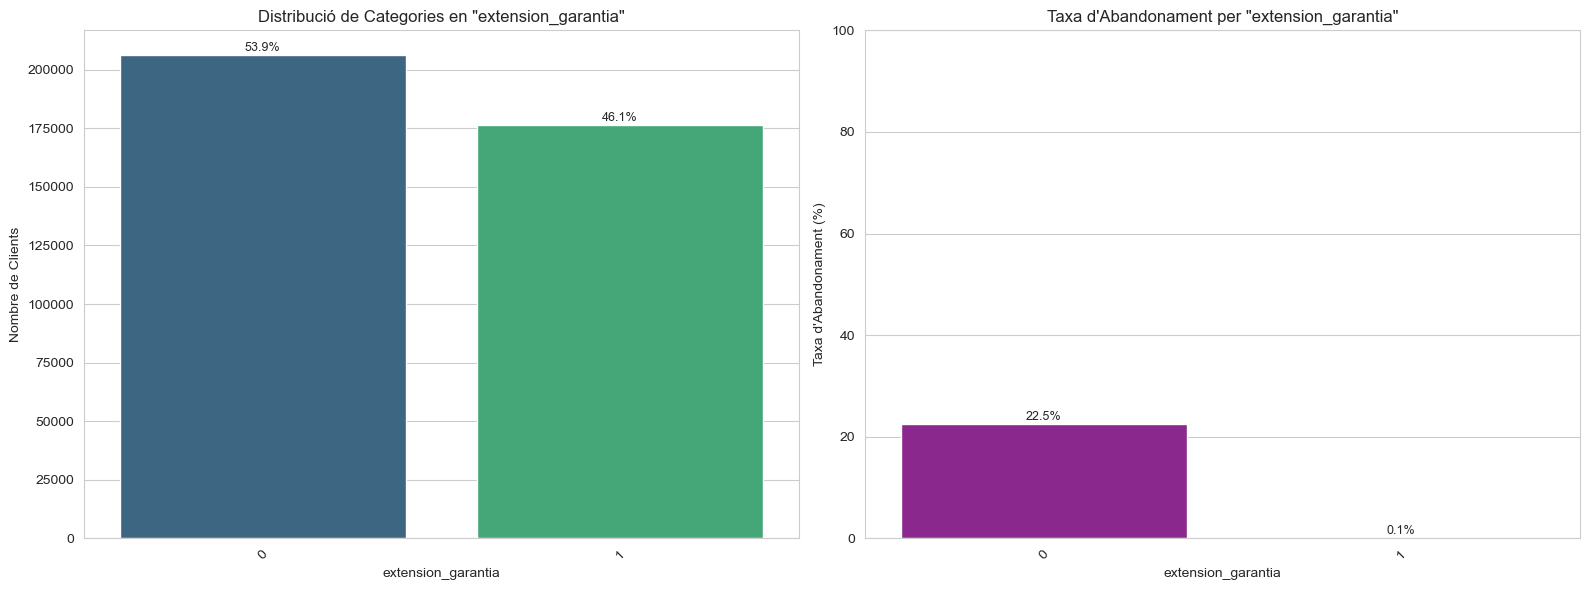




Generant gràfics per a la variable: 'antiguedad_vehiculo'...


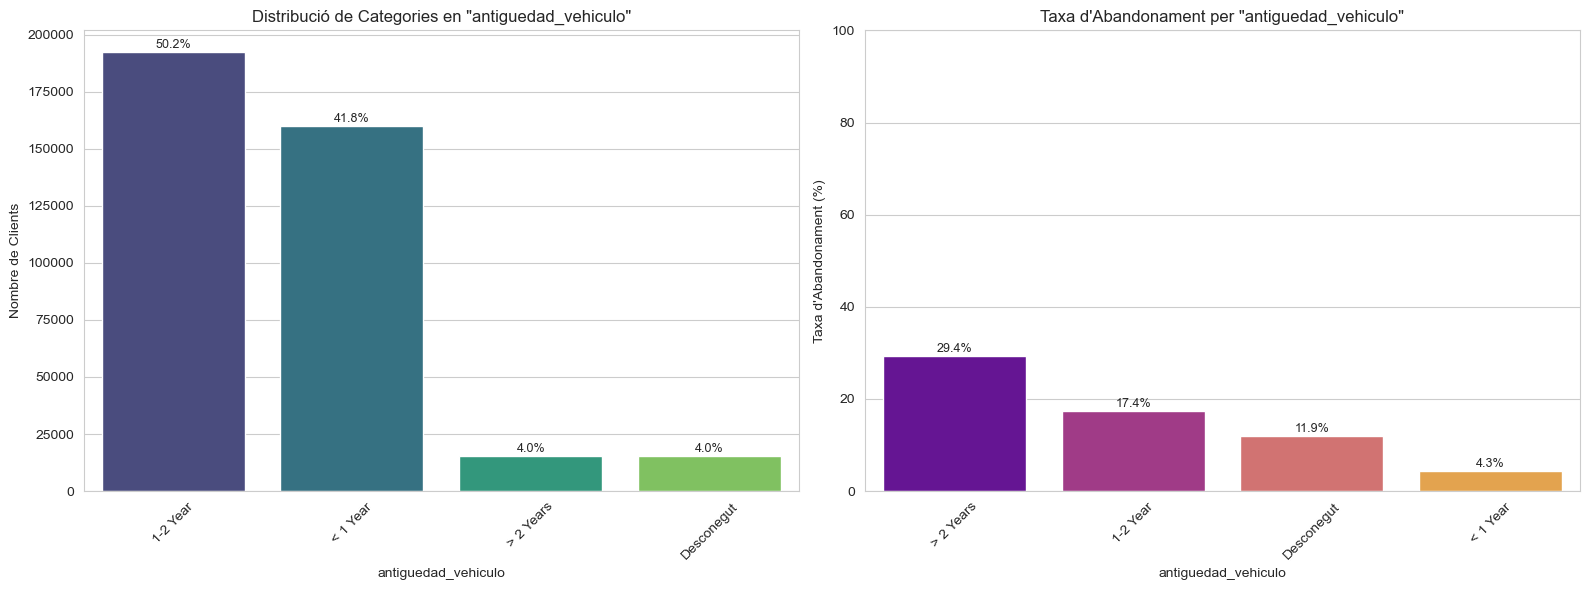




Generant gràfics per a la variable: 'siniestro'...


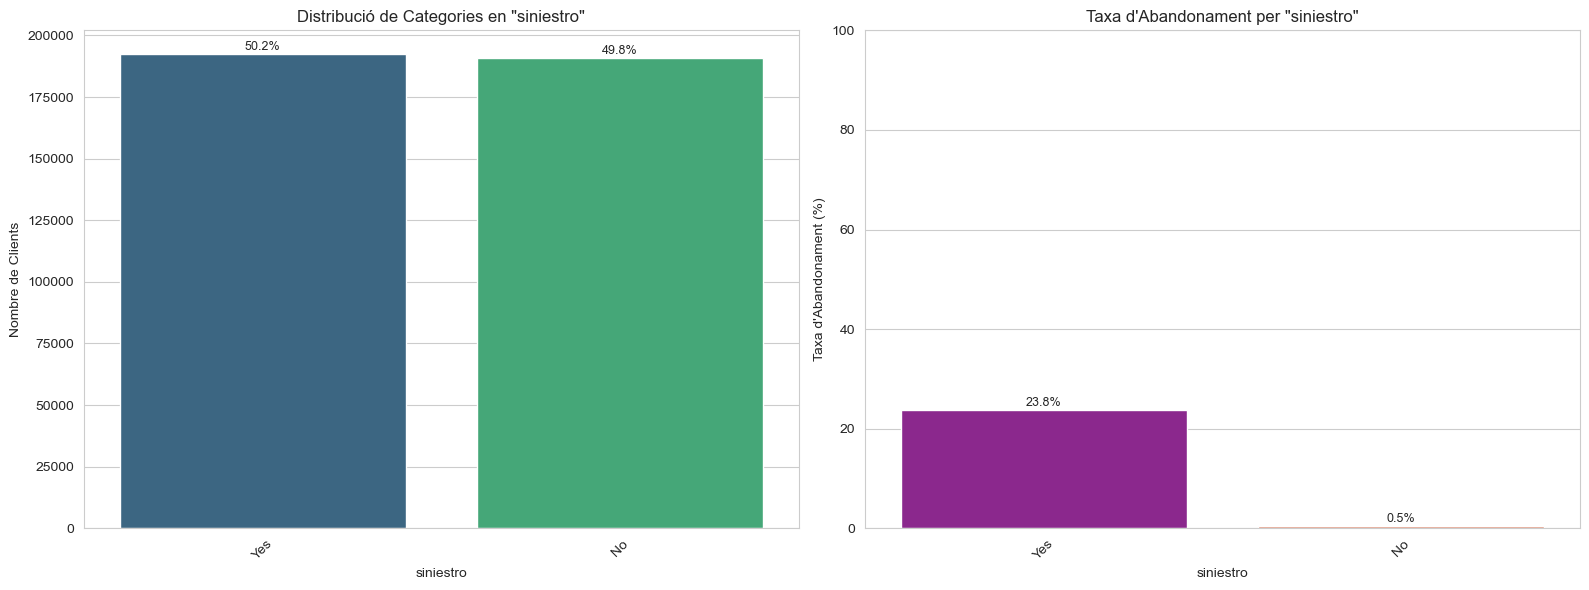




Generant gràfics per a la variable: 'oficina'...


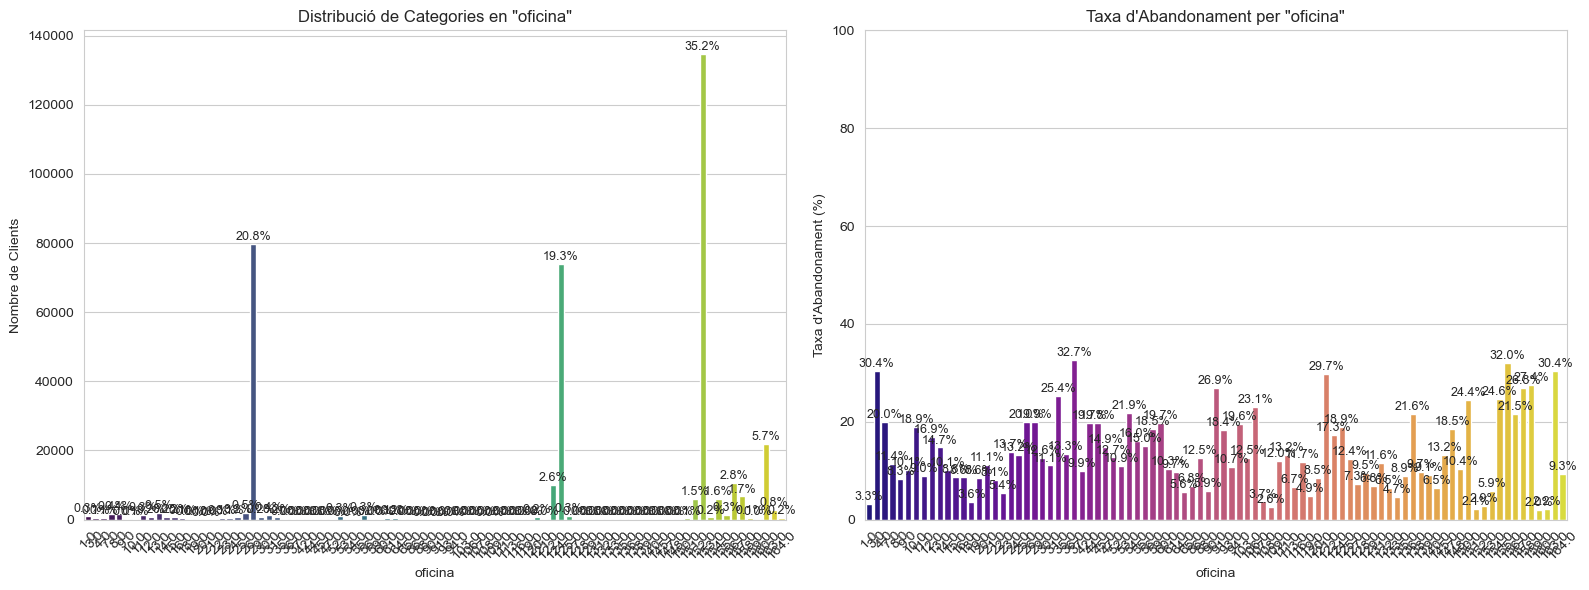



----------------------------------------------------------------------
FINAL DE L'EDA GRÀFICA PER VARIABLES CATEGÒRIQUES
----------------------------------------------------------------------


In [22]:
def plot_categorical_eda(df, categorical_cols, target_col):
    """
    Genera gràfics d'EDA per a variables categòriques:
    - Distribució de categories.
    - Taxa d'abandonament per categoria.

    Args:
        df (pd.DataFrame): El DataFrame de dades.
        categorical_cols (list): Llista de noms de columnes categòriques a analitzar.
        target_col (str): Nom de la columna objectiu (variable de resposta, 0 o 1).
    """

    print("-" * 70)
    print("INICI DE L'EDA GRÀFICA PER VARIABLES CATEGÒRIQUES")
    print("-" * 70)

    for col in categorical_cols:
        print(f"\nGenerant gràfics per a la variable: '{col}'...")

        # 1. Calcular freqüències i percentatges to al primer gràfic
        counts = df[col].value_counts(dropna=False)
        percentages = df[col].value_counts(normalize=True, dropna=False) * 100

        # Crear a DataFrame to als percentatges to facilitar el plot
        plot_df_dist = pd.DataFrame({
            'Category': counts.index,
            'Count': counts.values,
            'Percentage': percentages.values
        }).sort_values(by='Count', ascending=False) # Ordenar to freqüència

        # 2. Calcular la taxa d'abandonament to categoria to al segon gràfic
        # La mitjana of 0s i 1s dóna la proporció of 1s (abandonament)
        churn_rate = df.groupby(col)[target_col].mean().reset_index()
        churn_rate.columns = ['Category', 'Churn_Rate']
        churn_rate['Churn_Rate_Percent'] = churn_rate['Churn_Rate'] * 100
        # Ordenar to taxa d'abandonament to veure the categories of més risc
        churn_rate = churn_rate.sort_values(by='Churn_Rate_Percent', ascending=False)

        # Configuració of la figura with dos subplots
        fig, axes = plt.subplots(1, 2, figsize=(16, 6)) # a costat a l'altre to comparar

        # Gràfic 1: Distribució of Categories
        sns.barplot(x='Category', y='Count', data=plot_df_dist, palette='viridis', ax=axes[0])
        axes[0].set_title(f'Distribució de Categories en "{col}"')
        axes[0].set_ylabel('Nombre de Clients')
        axes[0].set_xlabel(col)
        axes[0].tick_params(axis='x', rotation=45) # Rotar etiquetes to a millor lectura si cal

        # Afegir percentatges a dalt of the barres
        for p in axes[0].patches:
            height = p.get_height()
            if not np.isnan(height): # Check for NaN if any category was empty
                axes[0].annotate(f'{height/len(df)*100:.1f}%',
                                 (p.get_x() + p.get_width() / 2., height),
                                 ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=9)

        # Gràfic 2: Taxa d'Abandonament to Categoria
        sns.barplot(x='Category', y='Churn_Rate_Percent', data=churn_rate, palette='plasma', ax=axes[1])
        axes[1].set_title(f'Taxa d\'Abandonament per "{col}"')
        axes[1].set_ylabel('Taxa d\'Abandonament (%)')
        axes[1].set_xlabel(col)
        axes[1].set_ylim(0, 100) # L'eix Y va of 0 a 100 to a percentatges
        axes[1].tick_params(axis='x', rotation=45) # Rotar etiquetes si cal

        # Afegir the valors of percentatge a dalt of the barres
        for p in axes[1].patches:
            height = p.get_height()
            if not np.isnan(height):
                axes[1].annotate(f'{height:.1f}%',
                                 (p.get_x() + p.get_width() / 2., height),
                                 ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=9)

        plt.tight_layout() # Ajusta el disseny to evitar solapament
        plt.show()

        print("\n" + "=" * 60 + "\n") # Separador to claredat entre variables

    print("-" * 70)
    print("FINAL DE L'EDA GRÀFICA PER VARIABLES CATEGÒRIQUES")
    print("-" * 70)

# Llista of the teves columnes categòriques
categorical_features = ['sexo', 'region', 'extension_garantia', 'antiguedad_vehiculo', 'siniestro', 'oficina']

# Assegura't que la columna 'oficina' és of tipus 'object' o 'category' si la vols tractar com a categòrica
# df['oficina'] = df['oficina'].astype(str) # Si ve com a int, converteix-la a string to tractar-la com a categòrica

# Executar la funció
plot_categorical_eda(df, categorical_features, 'respuesta')

Now that we have all the categorical variables with their data and graphs to visualize them, let’s discuss them:

* **Sex:** The distribution between men and women is quite balanced, with a slight majority of men. The percentage of "Unknown" (almost 8%) is significant. Regarding the churn rate, it is higher in men (by about 3%).

* **Region:** Assuming each number corresponds to the INE code for each province (which makes sense since the largest provinces—Barcelona, Madrid, and Valencia—have the highest numbers), there is a clear relationship between population size and the number of clients. There doesn’t appear to be a bias affecting smaller provinces, as they nearly reach 200 entries. In terms of churn rate, there are clear geographic differences: the highest churn is in Santa Cruz de Tenerife at 19%, while the lowest is in Teruel at 4%.

* **Extended Warranty:** The split is fairly even between those who have it (46%) and those who don’t (54%), but it is one of the most unbalanced factors in terms of churn. Clients without an extended warranty churn at a rate of 22%, while those with it churn at only 0.1%. This is clearly one of the most decisive factors for the model.

* **Vehicle Age:** The data is very uneven, as 92% of vehicles are less than two years old. The churn behavior varies widely: cars less than one year old have a churn rate of 4.31%, those between 1 and 2 years old have 17.4%, and cars older than 2 years have almost 30%. This finding should be shared with other departments (such as sales and marketing) and analyzed alongside the types of offers/promotions and contracts we provide, to understand why many clients do not continue after 2 years. This will be a very important factor for the model.

* **Claim:** The proportion is almost equal, with about 50% for “yes” and “no.” The churn rate changes drastically, though: clients without claims almost never churn (0.51%), while those who have had a claim churn 24% of the time. This is again an important factor for the model and one that could be shared to study what happens to customers who have had an accident, as there are many types, from minor dents to total losses.

* **Office:** This variable has the most categories, even after grouping some together. As previously mentioned, the top 3 offices group 75% of the clients. The churn rate varies widely by office, from as low as 2% to as high as 30%.

### 2.3 Quantitative data

----------------------------------------------------------------------
ANÀLISI EDA DE VARIABLES QUANTITATIVES
----------------------------------------------------------------------

# ## Anàlisi of la variable: 'edad' ###
---------------------------------

Estadístiques Descriptives:
count    383110.000000
mean         38.456720
std          14.744979
min          20.000000
25%          25.000000
50%          36.000000
75%          48.000000
max          85.000000

Asimetria (Skewness): 0.7688
Curtosi (Kurtosis): -0.2494

Valors Atípics (Regla de l'IQR - 1.5 * IQR): 41 trobats
  Min/Max atípics: 83.00 / 85.00
Valors Atípics (Z-score > 3): 41 trobats
  Min/Max atípics (Z-score): 83.00 / 85.00

Taxa d'Abandonament per Quartils de 'edad':
quartil
Q1     3.458712
Q2    12.144806
Q3    21.456680
Q4    14.280861


# ## Anàlisi of la variable: 'precio' ###
-----------------------------------

Estadístiques Descriptives:
count    383110.000000
mean       3877.164026
std        1699.053400
min 

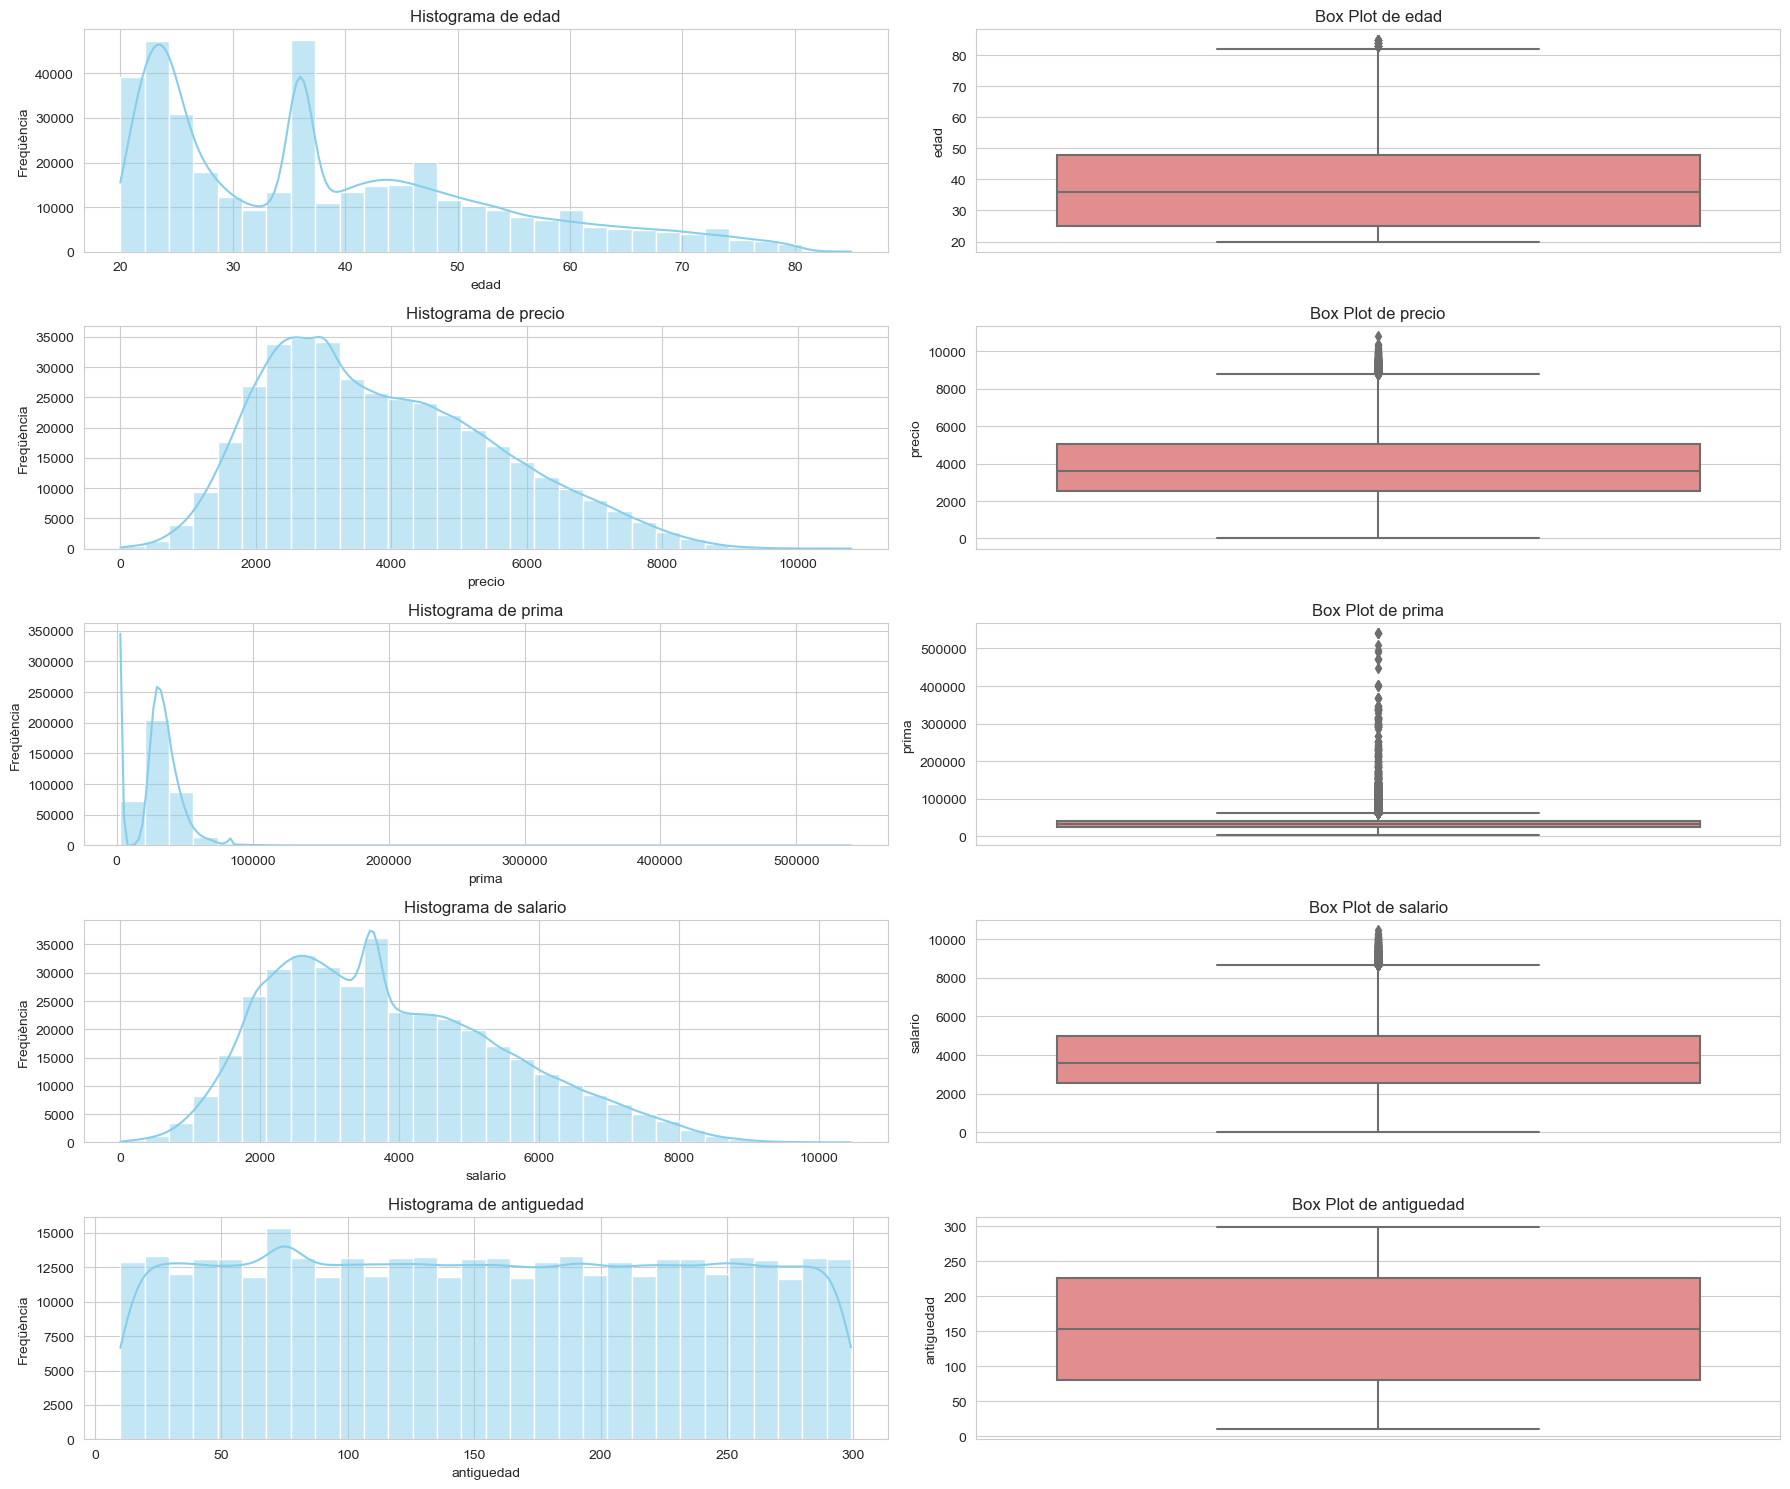


RELACIÓ DE VARIABLES QUANTITATIVES AMB LA VARIABLE OBJECTIU ('respuesta')


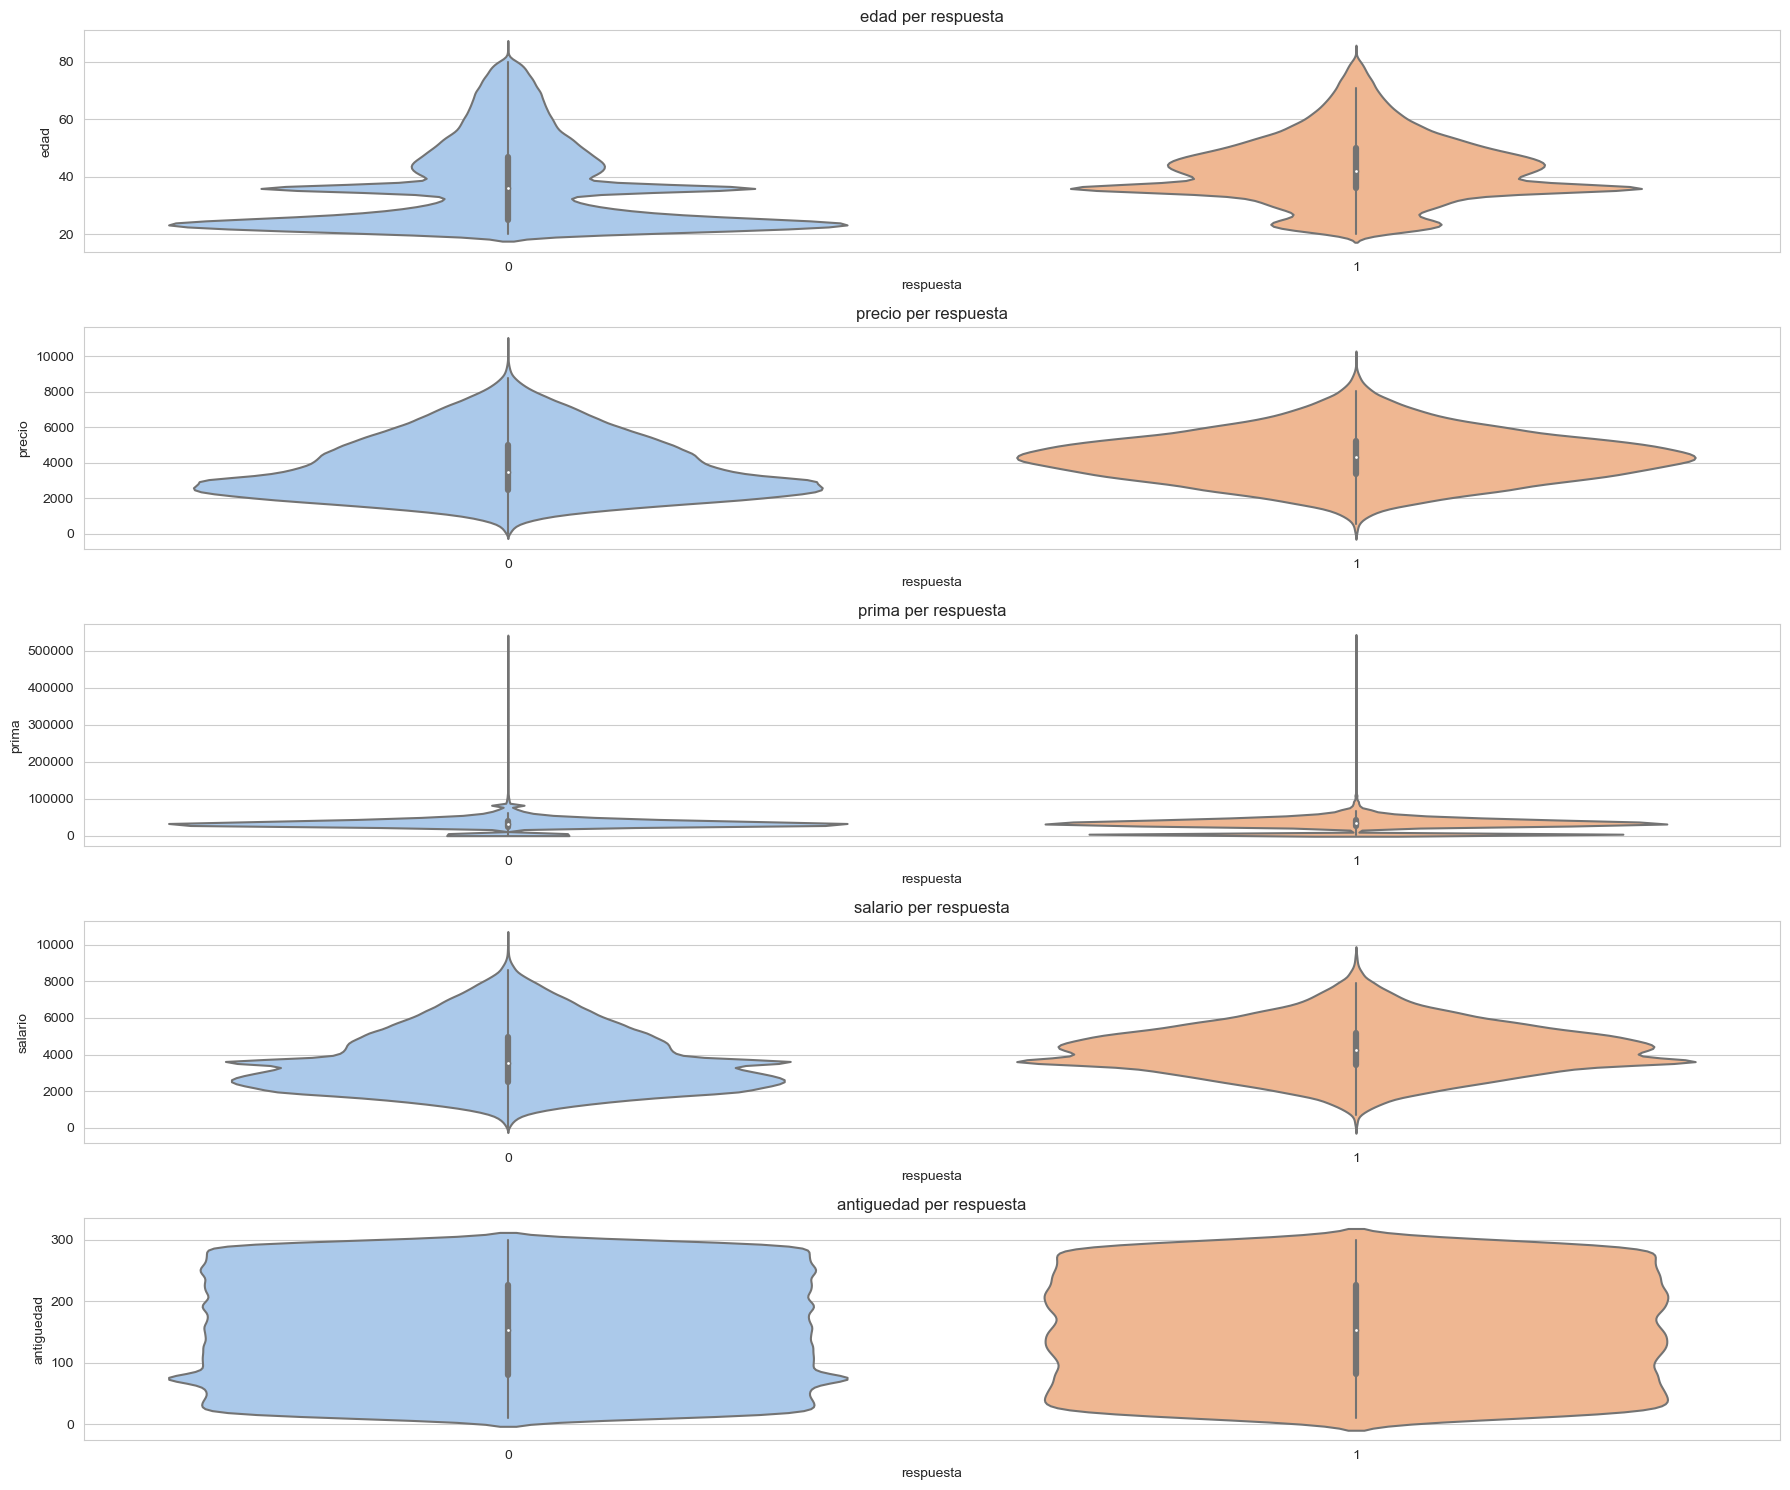

In [23]:
quantitative_cols = ['edad', 'precio', 'prima', 'salario', 'antiguedad']
categorical_features = ['sexo', 'permiso_conducir', 'region', 'extension_garantia', 'siniestro', 'oficina'] 
target_col = 'respuesta'

def print_quantitative_eda(df, quantitative_cols, target_col):
    """
    Imprimeix les estadístiques descriptives, asimetria, curtosi i informació de valors atípics
    per a cada columna quantitativa, i la mitjana de la variable objectiu per als quartils.

    Args:
        df (pd.DataFrame): El DataFrame de dades.
        quantitative_cols (list): Llista de noms de columnes quantitatives a analitzar.
        target_col (str): Nom de la columna objectiu (variable de resposta, 0 o 1).
    """
    print("-" * 70)
    print("ANÀLISI EDA DE VARIABLES QUANTITATIVES")
    print("-" * 70)

    for col in quantitative_cols:
        print(f"\n# ## Anàlisi of la variable: '{col}' ###")
        print("-" * (29 + len(col)))

        # 1. Estadístiques Descriptives
        print("\nEstadístiques Descriptives:")
        print(df[col].describe().to_string()) # .to_string() to assegurar que es mostren totes the files

        # 2. Asimetria i Curtosi
        print(f"\nAsimetria (Skewness): {df[col].skew():.4f}")
        print(f"Curtosi (Kurtosis): {df[col].kurt():.4f}")

        # 3. Anàlisi of Valors Atípics (basada in IQR i Z-score)
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers_iqr = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        print(f"\nValors Atípics (Regla de l'IQR - 1.5 * IQR): {len(outliers_iqr)} trobats")
        if not outliers_iqr.empty:
            print(f"  Min/Max atípics: {outliers_iqr[col].min():.2f} / {outliers_iqr[col].max():.2f}")
            # Considerar mostrar a subconjunt si hi ha molts
            # print(outliers_iqr[[col, target_col]].head()) # Mostra the primers

        # Z-score (si la distribució és raonablement simètrica)
        # Cal gestionar NaNs si no s'han tractat abans
        temp_col_no_nan = df[col].dropna()
        if not temp_col_no_nan.empty:
            outliers_zscore = temp_col_no_nan[np.abs(zscore(temp_col_no_nan)) > 3] # Threshold of 3
            print(f"Valors Atípics (Z-score > 3): {len(outliers_zscore)} trobats")
            if not outliers_zscore.empty:
                 print(f"  Min/Max atípics (Z-score): {outliers_zscore.min():.2f} / {outliers_zscore.max():.2f}")


        # 4. Taxa d'Abandonament (target_col) to Quartils
        print(f"\nTaxa d'Abandonament per Quartils de '{col}':")
        # Crea quartils to a la columna quantitativa
        df_temp = df.copy() # Treballem with a còpia to evitar SettingWithCopyWarning
        df_temp['quartil'] = pd.qcut(df_temp[col], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'], duplicates='drop')

        churn_rate_by_quartile = df_temp.groupby('quartil')[target_col].mean() * 100
        print(churn_rate_by_quartile.to_string())

        print("\n" + "=" * 60) # Separador to claredat

# Executar la funció to a the variables quantitatives
print_quantitative_eda(df, quantitative_cols, 'respuesta')

# --- Visualitzacions to a the variables quantitatives ---
print("\n" + "=" * 70)
print("VISUALITZACIONS EDA DE VARIABLES QUANTITATIVES")
print("=" * 70)

plt.figure(figsize=(18, 15)) # Ajusta la mida to a totes the gràfiques

for i, col in enumerate(quantitative_cols):
    # Histograma with KDE
    plt.subplot(len(quantitative_cols), 2, 2*i + 1)
    sns.histplot(df[col].dropna(), kde=True, bins=30, color='skyblue')
    plt.title(f'Histograma de {col}')
    plt.xlabel(col)
    plt.ylabel('Freqüència')

    # Box Plot with swarmplot to visualitzar individualment the punts
    plt.subplot(len(quantitative_cols), 2, 2*i + 2)
    sns.boxplot(y=df[col].dropna(), color='lightcoral')
    # sns.swarmplot(y=df[col].dropna(), color='black', alpha=0.5, size=3) # Pot ser molt lent to a moltes dades
    plt.title(f'Box Plot de {col}')
    plt.ylabel(col)

plt.tight_layout()
plt.show()

# Visualització of la relació with la variable objectiu 'respuesta'
print("\n" + "=" * 70)
print("RELACIÓ DE VARIABLES QUANTITATIVES AMB LA VARIABLE OBJECTIU ('respuesta')")
print("=" * 70)

plt.figure(figsize=(18, 15))
for i, col in enumerate(quantitative_cols):
    plt.subplot(len(quantitative_cols), 1, i + 1)
    sns.violinplot(x=target_col, y=col, data=df, palette='pastel')
    plt.title(f'{col} per {target_col}')
    plt.xlabel(target_col)
    plt.ylabel(col)
plt.tight_layout()
plt.show()

Now that we have all the quantitative variables with their data and graphs for visualization, let’s discuss them:

* **Age:** We see that young people (20-26 years old) represent a much higher percentage than the rest. There is a peak at the median, but that’s because we placed unknown data there. Apart from this, the age of clients gradually decreases up to 85 years. The churn rate increases significantly with age, being highest in the third quartile (21.46%) and lowest among young people (3%).

* **Price:** The average price is 3,877. Outliers: 689 outliers detected by IQR and 411 by Z-score, all high price values (above 8,790). However, since these are not excessive prices (less than 3 times the average) and there are enough of them (not just a single value that contributes to overfitting), we keep them. Churn clearly increases with price, reaching its peak in the third quartile (19.21%), then slightly decreases in the highest quartile.

* **Premium:** It has a very long tail, but enough values (12,035 out of 62,219 fall between 54,165 and 540,165). The median is 31,738. The churn percentage fluctuates between 11% and 14% for the 1st and 4th quantiles.

* **Salary:** The median salary is 3,607, with moderate dispersion and slight positive skewness (and a peak at the median because we placed missing values there). There are 980 outliers detected by IQR for high salaries (starting from 8,650). Still, they don’t cause overfitting. The churn rate increases progressively with salary up to the third quartile (19.20%), then slightly decreases in the highest quartile.

* **Seniority:** Seniority ranges from 10 to 299. We see that this factor alone does not influence churn, as all quartiles remain around 12% and the histogram is almost flat. If we don’t find it related to any other variable, we will remove it.


Matriu d'Associació Mixta


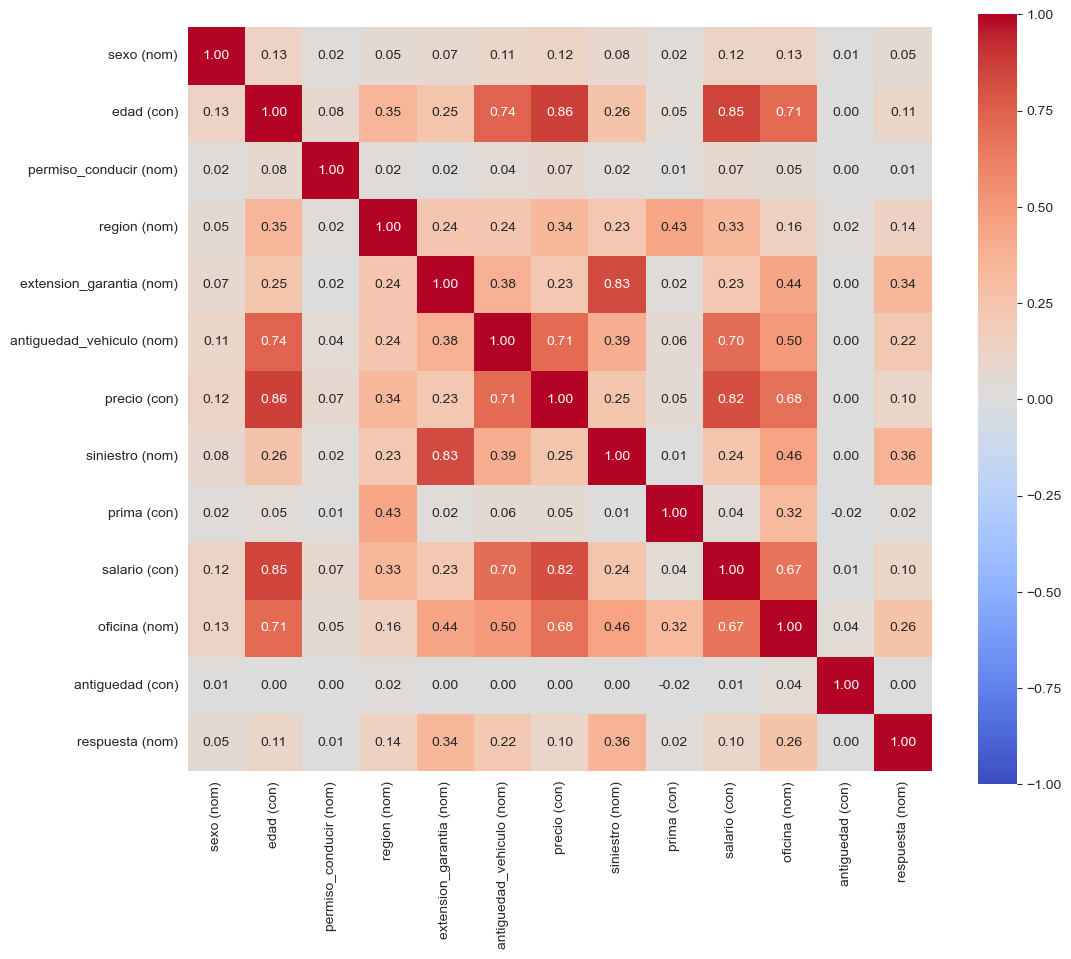

<Figure size 1000x600 with 0 Axes>


Matriu de coeficients generada (DataFrame):
                           sexo (nom)  edad (con)  permiso_conducir (nom)  \
sexo (nom)                       1.00        0.13                    0.02   
edad (con)                       0.13        1.00                    0.08   
permiso_conducir (nom)           0.02        0.08                    1.00   
region (nom)                     0.05        0.35                    0.02   
extension_garantia (nom)         0.07        0.25                    0.02   
antiguedad_vehiculo (nom)        0.11        0.74                    0.04   
precio (con)                     0.12        0.86                    0.07   
siniestro (nom)                  0.08        0.26                    0.02   
prima (con)                      0.02        0.05                    0.01   
salario (con)                    0.12        0.85                    0.07   
oficina (nom)                    0.13        0.71                    0.05   
antiguedad (con)               

In [24]:
categorical_features_for_dython = [
    'sexo',
    'region',
    'permiso_conducir',  
    'extension_garantia',
    'siniestro',
    'oficina',
    'antiguedad_vehiculo',
    'respuesta'
]

# Generar la matriu d'associació mixta with dython
print("\nMatriu d'Associació Mixta")
correlation_matrix_mixed_dython = associations(
    df,
    nominal_columns=categorical_features_for_dython,
    mark_columns=True,
    cmap='coolwarm',
    fmt=".2f",
    figsize=(12, 10)
)

plt.suptitle('Matriu d\'Associació Mixta (Diferents Coeficients)', y=1.02, fontsize=16)
plt.show()

print("\nMatriu de coeficients generada (DataFrame):")
print(correlation_matrix_mixed_dython['corr'].round(2))

Let’s start with **Driver’s License**. We have seen that there is no strong relationship with any other variable, and for this reason (and as mentioned before), we will remove it. The same goes for **Seniority**.

In [25]:
df.drop(columns=['permiso_conducir'], inplace=True)
df.drop(columns=['antiguedad'], inplace=True)

For the quantitative-quantitative relationships, we observe a strong positive correlation (which is quite expected) among the trio: age, price, and salary.

For quantitative-categorical relationships, there are connections between these three variables and vehicle age, as well as between these three and the office variable.

Among categorical-categorical relationships, there’s a link between extended warranty and claim status.

Let’s now evaluate the categorical variables a bit more in depth:

In [26]:
print("\nMitjana d'edat del client per categoria d'antiguitat del vehicle:")
print(df.groupby('antiguedad_vehiculo')['edad'].mean().round(2))


Mitjana d'edat del client per categoria d'antiguitat del vehicle:
antiguedad_vehiculo
1-2 Year      47.72
< 1 Year      25.90
> 2 Years     53.26
Desconegut    38.59
Name: edad, dtype: float64


We see that the youngest clients have the newest vehicles, while the oldest have the oldest ones. (Therefore, higher salaries and higher prices are associated with older vehicles, and lower salaries and prices with newer ones.)

In [27]:
print("\nMitjana d'edat del client per categoria d'antiguitat del vehicle:")
print(df.groupby('oficina')['edad'].mean().round(2))


Mitjana d'edat del client per categoria d'antiguitat del vehicle:
oficina
1.0      39.98
3.0      55.32
4.0      47.29
7.0      52.38
8.0      51.53
         ...  
158.0    42.09
159.0    22.57
160.0    24.72
163.0    37.18
164.0    50.32
Name: edad, Length: 89, dtype: float64


The fact that offices are related means that each office tends to have a clientele with a certain age, salary, and price range, but this relationship is not linear (for example, Office 1 doesn’t necessarily have the youngest clients, nor does Office 163 have the oldest).

This insight is quite surprising and could be shared with the marketing team so they can study the target customer for each office more closely.

In [28]:
print(df[(df['extension_garantia']== 0)& (df['siniestro']=='Yes')].shape[0] / df[(df['extension_garantia']== 0)].shape[0] * 100)
print(df[(df['extension_garantia']== 1)& (df['siniestro']=='Yes')].shape[0] / df[(df['extension_garantia']== 1)].shape[0] * 100)
print(df[(df['extension_garantia']==0) & (df['siniestro']=='No')].shape[0] / df[(df['extension_garantia']==0)].shape[0] * 100)
print(df[(df['extension_garantia']==1) & (df['siniestro']=='No')].shape[0] / df[(df['extension_garantia']==1)].shape[0] * 100)

88.3814975712051
5.617424092306473
11.618502428794901
94.38257590769352


We observe a strong relationship where 94% of those who have an extended warranty have not had an accident, and among those who don’t have it, many have had an accident. This is likely explained by the offers made, but it could also be worth studying further. Unfortunately, there is no direct relationship with churn.

For this reason, we are now preparing to develop a Supervised Machine Learning model.

# Model training

We prepare the data and split it to evaluate the model (80/20).

In [29]:
X = df.drop(columns='respuesta')             
y = df['respuesta'] 
X['oficina'] = X['oficina'].astype('category')
X['region'] = X['region'].astype('category')

X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Això manté la proporció of classes
)

By using `stratify = y`, we balance the data since the classes are 88/12. We will try several models to find the best final one.

### Logistic Regression

We train the logistic regression model:

In [30]:
modelLR = LogisticRegression(
    solver='liblinear',
    random_state=42,
    class_weight='balanced', # Crucial to a classes desequilibrades!
    n_jobs=-1 # Utilitzar tots the nuclis of la CPU disponibles (potser no suportat to tots the solvers)
)

In [31]:
modelLR.fit(X_train, y_train)

c:\Users\Marc\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn(


LogisticRegression(class_weight='balanced', n_jobs=-1, random_state=42,
                   solver='liblinear')

In [32]:
# Cross-validation 5 folds, scoring roc_auc
scores = cross_val_score(
    modelLR,
    X, y,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1              
)

print("AUC de cada fold:", scores)
print("AUC mitjana:", scores.mean())

AUC de cada fold: [0.84842928 0.84967879 0.84740446 0.85113525 0.84637252]
AUC mitjana: 0.848604060052781


ModelRL has an average AUC of approximately 0.85. This indicates that the model performs consistently across different data subsets. It’s a high and good score, although this is expected with imbalanced data.

In [33]:
# Fes prediccions with the dades of test
y_pred = modelLR.predict(X_test)
y_proba = modelLR.predict_proba(X_test)[:, 1]


print("Accuracy test:", accuracy_score(y_test, y_pred))
print("AUC test:", roc_auc_score(y_test, y_proba))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification report:\n", classification_report(y_test, y_pred))


Accuracy test: 0.6912244525071128
AUC test: 0.8515100653308764
Confusion matrix:
 [[44150 23130]
 [  529  8813]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      0.66      0.79     67280
           1       0.28      0.94      0.43      9342

    accuracy                           0.69     76622
   macro avg       0.63      0.80      0.61     76622
weighted avg       0.90      0.69      0.74     76622



We see that the model is very good at detecting customers who churn, but one consequence is that it produces many false positives. Let’s check how the other models perform.

### Random Forest

In [34]:
modelRF = RandomForestClassifier(
    max_depth=35,
    n_jobs=-1,
    class_weight='balanced',
    random_state=42
)

The max\_depth was adjusted, and the optimal value found is 35; beyond that, the model starts to overfit. We proceed to train the model:

In [35]:
modelRF.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=35, n_jobs=-1,
                       random_state=42)

In [36]:
# Cross-validation 5 folds, scoring roc_auc
scores = cross_val_score(
    modelRF,
    X, y,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1              
)

print("AUC de cada fold:", scores)
print("AUC mitjana:", scores.mean())

AUC de cada fold: [0.84740296 0.84768596 0.84596972 0.85100576 0.84530289]
AUC mitjana: 0.8474734572631851


ModelRL has an average AUC of approximately 0.85. This indicates the model performs consistently across different data subsets. It’s a high and good score, although this is expected with imbalanced data.

In [37]:
# Fes prediccions with the dades of test
y_pred = modelRF.predict(X_test)
y_proba = modelRF.predict_proba(X_test)[:, 1]


print("Accuracy test:", accuracy_score(y_test, y_pred))
print("AUC test:", roc_auc_score(y_test, y_proba))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification report:\n", classification_report(y_test, y_pred))


Accuracy test: 0.785022578371747
AUC test: 0.8498390553535604
Confusion matrix:
 [[53426 13854]
 [ 2618  6724]]
Classification report:
               precision    recall  f1-score   support

           0       0.95      0.79      0.87     67280
           1       0.33      0.72      0.45      9342

    accuracy                           0.79     76622
   macro avg       0.64      0.76      0.66     76622
weighted avg       0.88      0.79      0.82     76622



There is a better balance between detecting churners and not bothering too many loyal customers. Although it detects fewer clients who leave, the ones it does identify are more reliable.

### Voting

Voting isn’t a “new model” per se; rather, it takes the Logistic Regression (modelLR) and Random Forest (modelRF), calculates their outputs, and—based on their predicted probabilities—chooses the most likely outcome for the client.

In [38]:
voting_clf = VotingClassifier(
    estimators=[
        ('lr', modelLR),
        ('rf', modelRF)
    ],
    voting='soft', # Fa servir the probabilitats
    n_jobs=-1 
)

In [39]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(class_weight='balanced',
                                                 n_jobs=-1, random_state=42,
                                                 solver='liblinear')),
                             ('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_depth=35, n_jobs=-1,
                                                     random_state=42))],
                 n_jobs=-1, voting='soft')

In [40]:
scores = cross_val_score(
    voting_clf,
    X, y,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)
print("AUC de cada fold:", scores)
print("AUC mitjana:", scores.mean())

AUC de cada fold: [       nan 0.8528518  0.85045933 0.85471774        nan]
AUC mitjana: nan


c:\Users\Marc\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
2 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Marc\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Marc\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Marc\anaconda3\Lib\site-packages\sklearn\ensemble\_voting.py", line 349, in fit
    return super().fit(X, tr

Voting has an average AUC of over 0.85. This indicates the model performs consistently across different data subsets. It’s a high and good score, although this is expected with imbalanced data.

In [41]:
y_pred = voting_clf.predict(X_test)
y_proba= voting_clf.predict_proba(X_test)[:, 1]

print("Accuracy test:", accuracy_score(y_test, y_pred))
print("AUC test:", roc_auc_score(y_test, y_proba))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification report:\n", classification_report(y_test, y_pred))

Accuracy test: 0.7439377724413354
AUC test: 0.8546326143729455
Confusion matrix:
 [[48984 18296]
 [ 1324  8018]]
Classification report:
               precision    recall  f1-score   support

           0       0.97      0.73      0.83     67280
           1       0.30      0.86      0.45      9342

    accuracy                           0.74     76622
   macro avg       0.64      0.79      0.64     76622
weighted avg       0.89      0.74      0.79     76622



It correctly predicts 74% of all cases; out of every 100 clients, it accurately guesses whether they will churn or not for 74 of them.

It has good capability for detecting customers who will churn: it identifies 86% of them (more than the RF model), but often makes mistakes by predicting that a client will churn when they actually won’t. Out of every 10 clients the model predicts will churn, only 3 actually do—but this is still fewer false positives than the LR model.

Overall, the model has a good score (AUC = 0.85), which indicates it distinguishes well between those who churn and those who don’t.

### Final Decision:

The models have been evaluated using Accuracy, AUC, Recall, Precision, and F1-score, placing special emphasis on the recall for class 1 (detecting churners) and balancing precision (to avoid unnecessary false positives). Results:

| Model               | Accuracy | AUC  | Recall (Class 1) | Precision (Class 1) | F1-score (Class 1) |
| ------------------- | -------- | ---- | ---------------- | ------------------- | ------------------ |
| Logistic Regression | 0.69     | 0.85 | 0.94             | 0.28                | 0.43               |
| Random Forest       | 0.79     | 0.85 | 0.72             | 0.33                | 0.45               |
| Voting Ensemble     | 0.74     | 0.85 | 0.86             | 0.30                | 0.45               |

We choose the **Voting Ensemble model** for the following reasons:

* It has the highest AUC (0.8546), indicating relatively good class separation capability.
* Maintains a very high recall (0.86), ensuring that most customers who will churn are detected.
* Offers a more reasonable balance between detecting positives and avoiding too many false positives.
* Combines the simplicity of logistic regression with the power of random forest.

We proceed to create the final model:


In [42]:
joblib.dump(voting_clf, 'model_entrenat.pkl')

['model_entrenat.pkl']